# Import the essentials

In [2]:
# Imports here
from __future__ import print_function, division
import numpy as np
import matplotlib.pyplot as plt
from torch.utils import data
import torch
from torch import nn
from torch import optim
import torchvision
import torch.nn.functional as F
from torchvision import datasets, transforms, models
import torchvision.models as models
from torch.utils.data.sampler import SubsetRandomSampler
from torch.utils.data import Dataset, DataLoader
from skimage import io, transform
import torch.utils.data as data_utils
from PIL import Image, ImageFile
from torch.optim import lr_scheduler
import os
import argparse
import seaborn as sns
import copy
import pandas as pd
ImageFile.LOAD_TRUNCATED_IMAGES = True
import cv2
# Import useful sklearn functions
import sklearn
from sklearn.metrics import cohen_kappa_score, accuracy_score
import time
from tqdm import tqdm_notebook
import seaborn as sns
import warnings

# Loading Data + EDA

In [3]:
train_csv = pd.read_csv('/kaggle/input/aptos2019-blindness-detection/train.csv')

test_csv = pd.read_csv('/kaggle/input/aptos2019-blindness-detection/test.csv')

In [4]:
print('Train Size = {}'.format(len(train_csv)))
print('Public Test Size = {}'.format(len(test_csv)))

Train Size = 3662
Public Test Size = 1928


In [5]:
train_csv.head()

,id_code,diagnosis
0,000c1434d8d7,2
1,001639a390f0,4
2,0024cdab0c1e,1
3,002c21358ce6,0
4,005b95c28852,0


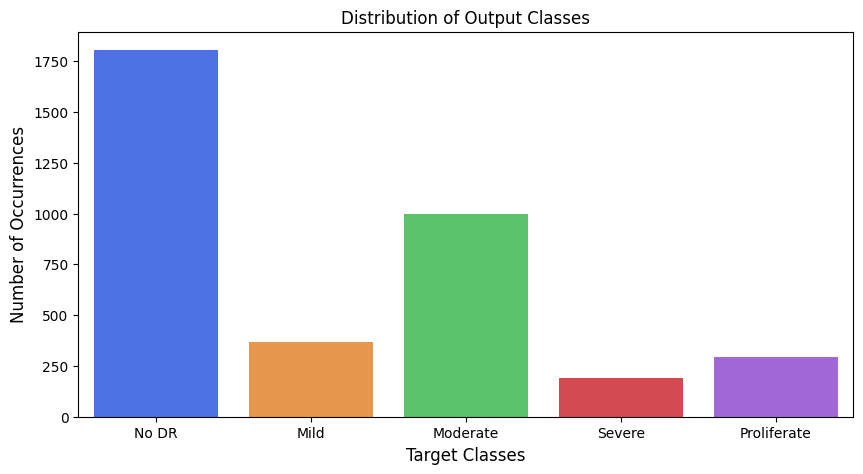

In [6]:
import matplotlib.pyplot as plt

import seaborn as sns



counts = train_csv['diagnosis'].value_counts()

class_list = ['No DR', 'Mild', 'Moderate', 'Severe', 'Proliferate']



for i, x in enumerate(class_list):

    counts[x] = counts.pop(i)



plt.figure(figsize=(10, 5))

sns.barplot(x=counts.index, y=counts.values, alpha=0.8, palette='bright')

plt.title('Distribution of Output Classes')

plt.xlabel('Target Classes', fontsize=12)

plt.ylabel('Number of Occurrences', fontsize=12)

plt.show()

# Visualizing Training Data

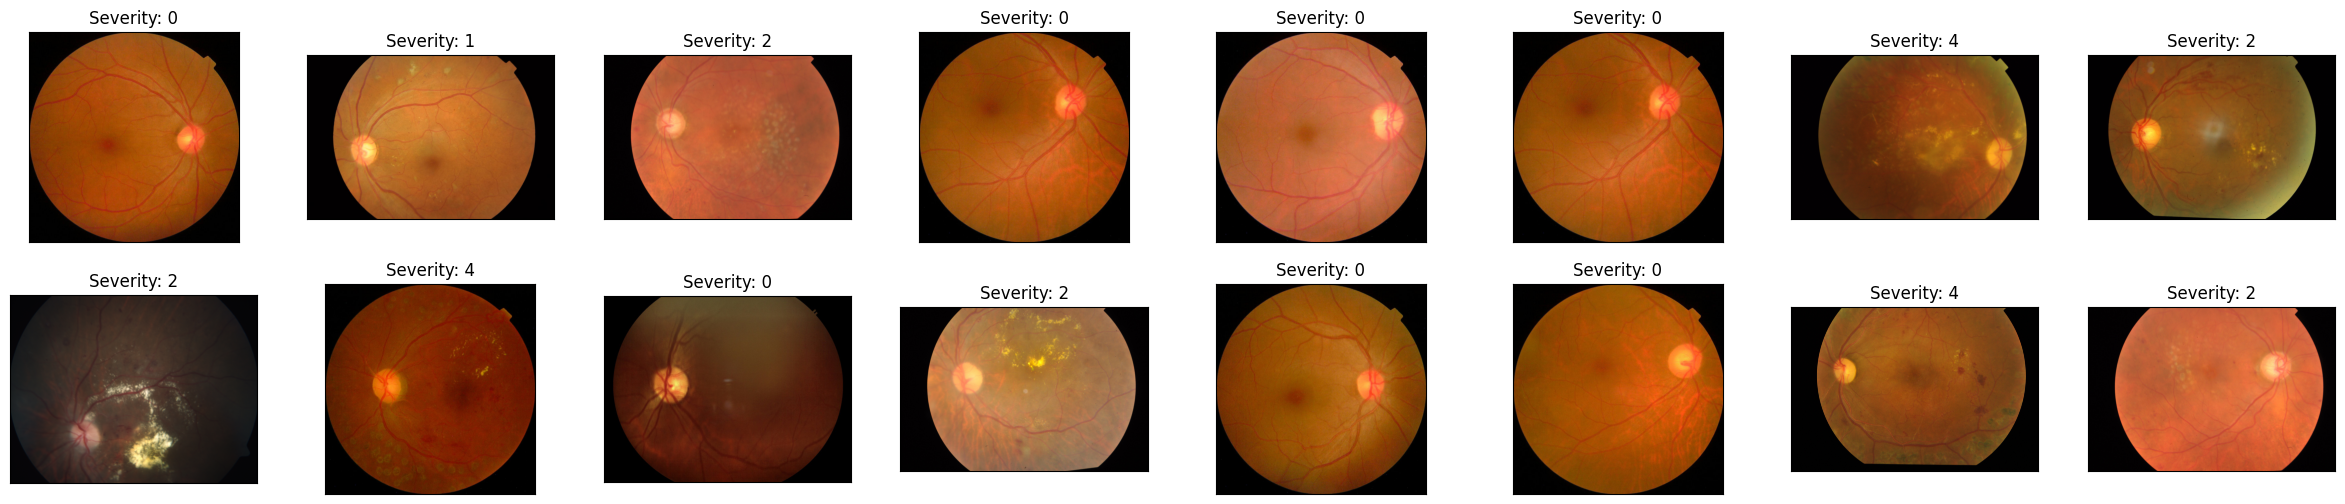

In [7]:
import os
import numpy as np
import matplotlib.pyplot as plt
from PIL import Image
# Define base directory

base_dir = '/kaggle/input/aptos2019-blindness-detection'
# List of image files in the training images folder

train_imgs = os.listdir(os.path.join(base_dir, 'train_images'))



# Plotting images
fig = plt.figure(figsize=(30, 6))
# Display 16 random images
for idx, img in enumerate(np.random.choice(train_imgs, 16)):
    ax = fig.add_subplot(2, 16 // 2, idx + 1, xticks=[], yticks=[])
    im = Image.open(os.path.join(base_dir, "train_images", img))
    plt.imshow(im)
    lab = train_csv.loc[train_csv['id_code'] == img.split('.')[0], 'diagnosis'].values[0]
    ax.set_title('Severity: %s' % lab)

plt.show()

# Visualizing Test Data


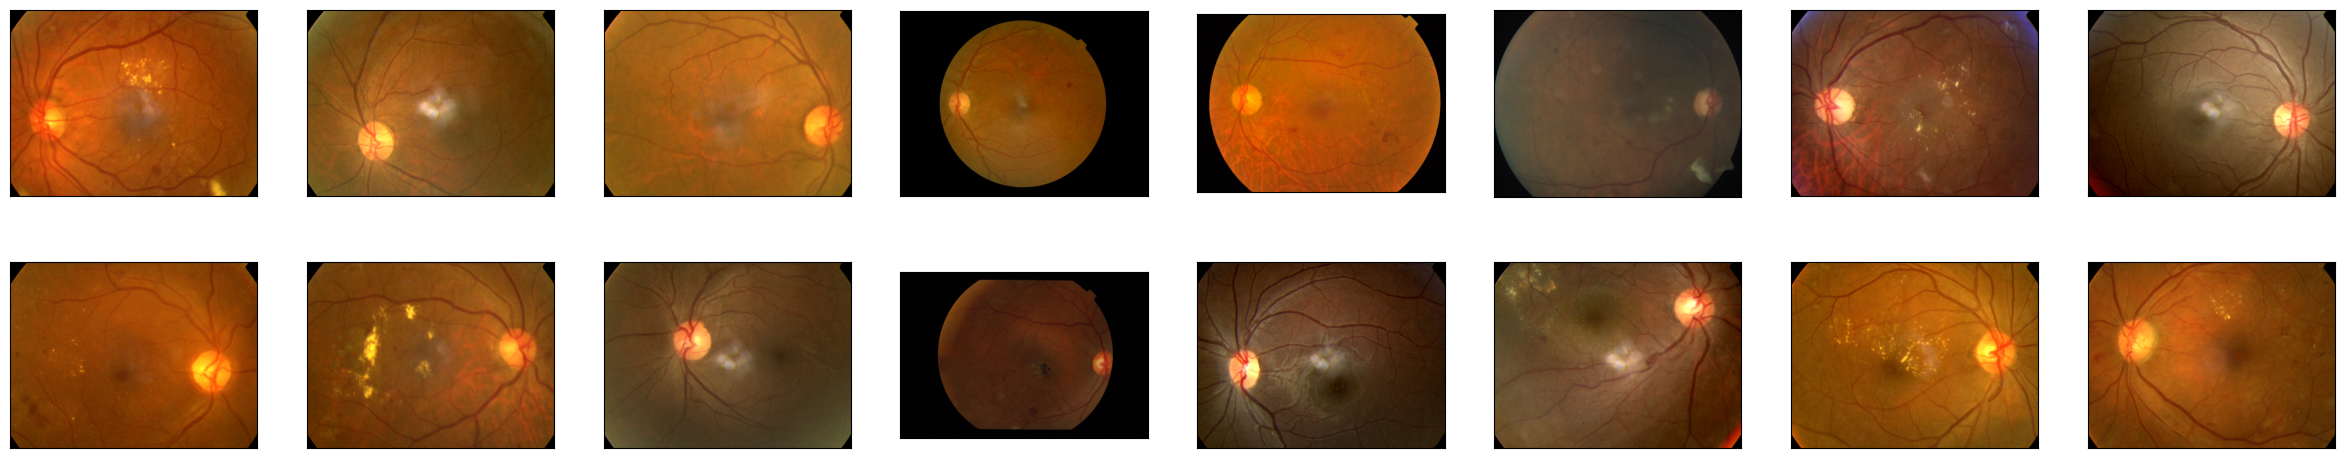

In [8]:
fig = plt.figure(figsize=(30, 6))

# display 20 images

test_imgs = os.listdir(base_dir+"/test_images")

for idx, img in enumerate(np.random.choice(test_imgs, 16)):

    ax = fig.add_subplot(2, 16//2, idx+1, xticks=[], yticks=[])

    im = Image.open(base_dir+"/test_images/" + img)

    plt.imshow(im)

# Data Pre Processing

In [9]:
class CreateDataset(Dataset):

    def __init__(self, df_data, data_dir = '../input/', transform=None):

        super().__init__()

        self.df = df_data.values

        self.data_dir = data_dir

        self.transform = transform



    def __len__(self):

        return len(self.df)



    def __getitem__(self, index):

        img_name,label = self.df[index]

        img_path = os.path.join(self.data_dir, img_name+'.png')

        image = cv2.imread(img_path)

        if self.transform is not None:

            image = self.transform(image)

        return image, label

In [10]:
train_transforms = transforms.Compose([

    transforms.ToPILImage(),

    transforms.Resize((256, 256)),

    transforms.RandomHorizontalFlip(p=0.4),

    transforms.ToTensor(),

    transforms.Normalize(mean=(0.485, 0.456, 0.406), std=(0.229, 0.224, 0.225))

])

In [11]:
test_transforms = transforms.Compose([transforms.Resize(256),

                                      transforms.CenterCrop(224),

                                      transforms.ToTensor(),

                                      transforms.Normalize([0.485, 0.456, 0.406],[0.229, 0.224, 0.225])])

In [14]:
train_path = "/kaggle/input/aptos2019-blindness-detection/train_images"

test_path = "/kaggle/input/aptos2019-blindness-detection/test_images"

In [15]:
train_data = CreateDataset(df_data=train_csv, data_dir=train_path, transform=train_transforms)

test_data = CreateDataset(df_data=test_csv, data_dir=test_path, transform=test_transforms)

In [16]:
valid_size = 0.2

num_train = len(train_data)

indices = list(range(num_train))

np.random.shuffle(indices)

split = int(np.floor(valid_size * num_train))

train_idx, valid_idx = indices[split:], indices[:split]

In [17]:
train_sampler = SubsetRandomSampler(train_idx)

valid_sampler = SubsetRandomSampler(valid_idx)

In [18]:
trainloader = torch.utils.data.DataLoader(train_data, batch_size=64,sampler=train_sampler)

validloader = torch.utils.data.DataLoader(train_data, batch_size=64, sampler=valid_sampler)

testloader = torch.utils.data.DataLoader(test_data, batch_size=64)

In [19]:
print(f"training examples contain : {len(train_data)}")

print(f"testing examples contain : {len(test_data)}")

training examples contain : 3662
testing examples contain : 1928


In [20]:
images, labels = next(iter(trainloader))

# Checking shape of image

print(f"Image shape : {images.shape}")

print(f"Label shape : {labels.shape}")



# denormalizing images for printing as they are in tensors

def imshow(inp, title=None):

    """Imshow for Tensor."""

    inp = inp.numpy().transpose((1, 2, 0))

    mean = np.array([0.485, 0.456, 0.406])

    std = np.array([0.229, 0.224, 0.225])

    inp = std * inp + mean

    inp = np.clip(inp, 0, 1)

    plt.imshow(inp)

    if title is not None:

        plt.title(title)

    plt.pause(0.001)

Image shape : torch.Size([64, 3, 256, 256])
Label shape : torch.Size([64])


labels: tensor([2, 1, 0, 2, 1, 1, 0, 0, 1, 2, 2, 4, 1, 0, 0, 1, 2, 0, 4, 4, 4, 2, 0, 0,
        0, 0, 2, 0, 2, 4, 2, 0, 0, 2, 0, 0, 2, 0, 0, 0, 2, 2, 0, 0, 2, 4, 0, 1,
        0, 0, 4, 2, 1, 0, 0, 4, 2, 0, 0, 2, 2, 2, 4, 1])


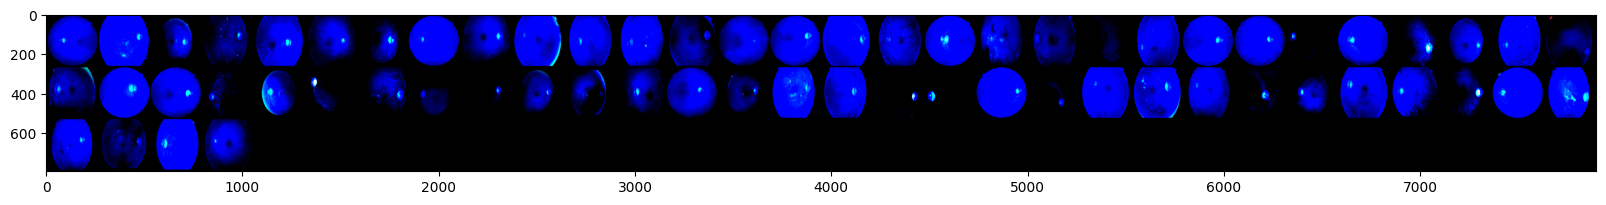

In [21]:
# plotting the images of loaded batch with given fig size and frame data

import torchvision

import matplotlib.pyplot as plt

import numpy as np

grid = torchvision.utils.make_grid(images, nrow=30, padding=7)

# Move the tensor to CPU before transposing

grid = grid.cpu()

plt.figure(figsize=(20, 20))

plt.imshow(np.transpose(grid, (1, 2, 0)))

print('labels:', labels)

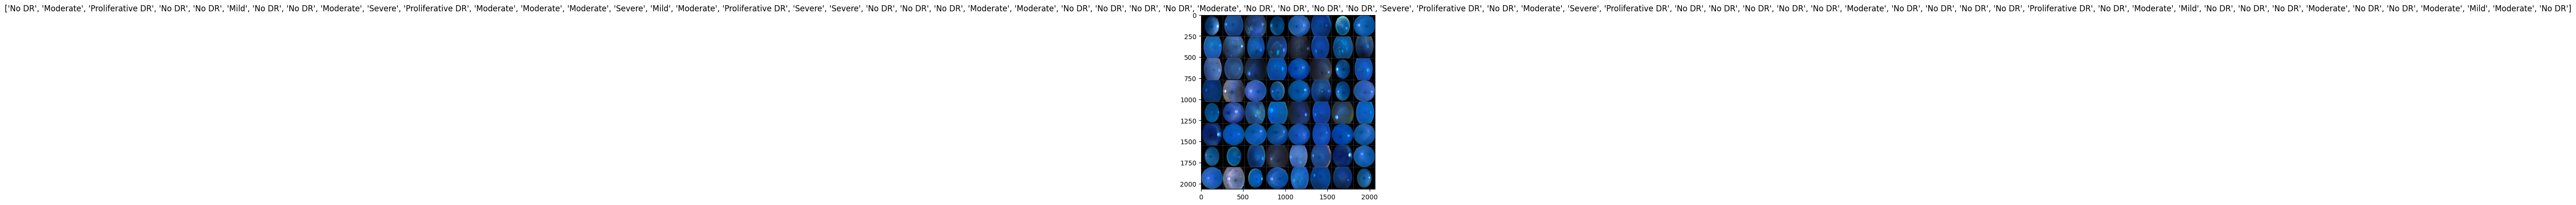

In [22]:
class_names = ['No DR', 'Mild', 'Moderate', 'Severe', 'Proliferative DR']



images, labels = next(iter(trainloader))

out = torchvision.utils.make_grid(images)

imshow(out, title=[class_names[x] for x in labels])

In [24]:
###SHUTIL####



import os

import shutil

import random



# Set the directory paths

train = '/kaggle/input/aptos2019-blindness-detection/train_images'

test = '/kaggle/input/aptos2019-blindness-detection/test_images'

# Create the validation directory if it doesn't exist

os.makedirs('test' , exist_ok=True)

os.makedirs('train' , exist_ok=True)

os.makedirs('val' , exist_ok=True)



t_df = pd.read_csv('/kaggle/input/aptos2019-blindness-detection/train.csv')



train_df = t_df.sample(frac = 0.80)

test_df = t_df.drop(train_df.index)

test_df.reset_index(drop=True, inplace=True)



val_df = test_df.sample(frac = 0.45)

test_df = test_df.drop(val_df.index)

test_df.reset_index(drop=True, inplace=True)

val_df.reset_index(drop=True, inplace=True)



train_df.sort_values(by='diagnosis', inplace=True)

train_df.reset_index(drop=True, inplace=True)



test_df.sort_values(by='diagnosis', inplace=True)

test_df.reset_index(drop=True, inplace=True)



val_df.sort_values(by='diagnosis', inplace=True)

val_df.reset_index(drop=True, inplace=True)

<Axes: ylabel='count'>

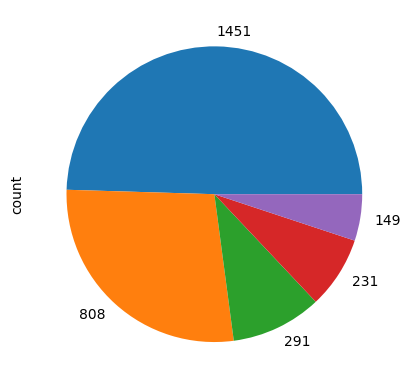

In [27]:
train_df['diagnosis'].value_counts().plot(kind='pie' , labels = list(train_df['diagnosis'].value_counts()))

<Axes: ylabel='count'>

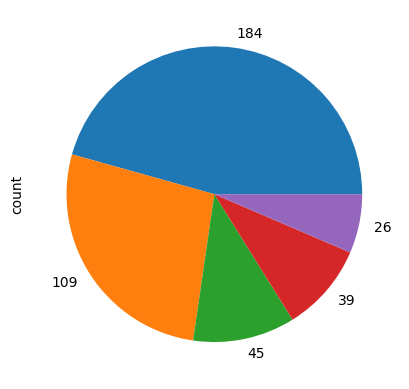

In [28]:
test_df['diagnosis'].value_counts().plot(kind='pie' , labels = list(test_df['diagnosis'].value_counts()))

<Axes: ylabel='count'>

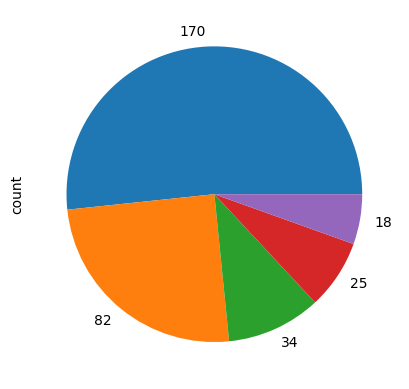

In [29]:
val_df['diagnosis'].value_counts().plot(kind='pie' , labels = list(val_df['diagnosis'].value_counts()))

In [30]:
for i in range(5):

  imgs = train_df[train_df['diagnosis'] == i]['id_code'].to_list()

  os.makedirs(os.path.join('train', str(i)), exist_ok=True)

  for j in imgs:

    shutil.copy(os.path.join(train, j+'.png'), os.path.join(f'train/{i}', str(j)+'.png'))

In [31]:
for i in range(5):

  imgs = test_df[test_df['diagnosis'] == i]['id_code'].to_list()

  os.makedirs(os.path.join('test', str(i)), exist_ok=True)

  for j in imgs:

    shutil.copy(os.path.join(train, j+'.png'), os.path.join(f'test/{i}', str(j)+'.png'))

In [32]:
for i in range(5):

  imgs = val_df[val_df['diagnosis'] == i]['id_code'].to_list()

  os.makedirs(os.path.join('val', str(i)), exist_ok=True)

  for j in imgs:

    shutil.copy(os.path.join(train, j+'.png'), os.path.join(f'val/{i}', str(j)+'.png'))

In [38]:
import os
directory_path = "/kaggle/working/test"
# Get the list of directories inside the specified directory
elements = os.listdir(directory_path)
print(f"Number of elements in each directory inside '{directory_path}':")
for element in elements:
    full_path = os.path.join(directory_path, element)
    if os.path.isdir(full_path):  # Check if the element is a directory
        num_elements = len(os.listdir(full_path))
        print(f"Directory: {element}, Number of elements: {num_elements}")

Number of elements in each directory inside '/kaggle/working/test':
Directory: 3, Number of elements: 26
Directory: 1, Number of elements: 45
Directory: 4, Number of elements: 39
Directory: 2, Number of elements: 109
Directory: 0, Number of elements: 184


In [ ]:
# Load the pretrained MobileNetV2 model
model = models.mobilenet_v2(pretrained=True)
num_classes = 5
in_features = model.last_channel
model.classifier = nn.Sequential(
    nn.Dropout(p=0.35),  # Add Dropout to prevent overfitting
    nn.Linear(in_features, num_classes)  
)

# Ensure the last 20 layers are trainable(finetuning)
for param in model.features[-20:].parameters():
    param.requires_grad = True

# Define loss function and optimizer
criterion = nn.CrossEntropyLoss()
optimizer = optim.Adam(filter(lambda p: p.requires_grad, model.parameters()), lr=0.00001)

# Define data transformations
transform = transforms.Compose([
    transforms.Resize((224, 224)),  # MobileNetV2 input size is 224x224
    transforms.RandomHorizontalFlip(p=0.4),
    transforms.RandomVerticalFlip(p=0.4),
    transforms.RandomRotation(degrees=(0, 10)),
    transforms.ToTensor(),
    transforms.Normalize(mean=[0.485, 0.456, 0.406], std=[0.229, 0.224, 0.225]),
])

# Prepare datasets and dataloaders
train_dataset = datasets.ImageFolder(root='/kaggle/working/train', transform=transform)
train_loader = DataLoader(train_dataset, batch_size=32, shuffle=True)

val_dataset = datasets.ImageFolder(root='/kaggle/working/val', transform=transform)
val_loader = DataLoader(val_dataset, batch_size=32, shuffle=False)


best_val_accuracy = 0.0
best_model_path = "best_model.pth"  # Path to save the best model

# Training loop
num_epochs = 10
for epoch in range(num_epochs):
    start_time = time.time()
    model.train()
    running_loss = 0.0
    correct_train = 0
    total_train = 0

    print(f"Epoch [{epoch + 1}/{num_epochs}] - Training...")

    for batch_idx, (images, labels) in enumerate(train_loader):
        images, labels = images.to(device), labels.to(device)

        # Forward pass
        outputs = model(images)
        loss = criterion(outputs, labels)

        # Backward pass and optimization
        optimizer.zero_grad()
        loss.backward()
        optimizer.step()

        running_loss += loss.item()

        # Calculate accuracy for this batch
        _, predicted = torch.max(outputs, 1)
        total_train += labels.size(0)
        correct_train += (predicted == labels).sum().item()

        if (batch_idx + 1) % 10 == 0:  # Print every 10 batches
            train_accuracy = 100 * correct_train / total_train
            print(f"Batch [{batch_idx + 1}/{len(train_loader)}] - "
                  f"Loss: {loss.item():.4f}, "
                  f"Train Accuracy: {train_accuracy:.2f}%")

    # Compute training loss and accuracy for the epoch
    train_loss = running_loss / len(train_loader)
    train_accuracy = 100 * correct_train / total_train

    # Validation loop
    model.eval()
    val_loss = 0.0
    correct_val = 0
    total_val = 0

    print(f"Epoch [{epoch + 1}/{num_epochs}] - Validating...")

    with torch.no_grad():
        for images, labels in val_loader:
            images, labels = images.to(device), labels.to(device)
            outputs = model(images)
            loss = criterion(outputs, labels)
            val_loss += loss.item()

            _, predicted = torch.max(outputs, 1)
            total_val += labels.size(0)
            correct_val += (predicted == labels).sum().item()

    # Compute validation loss and accuracy
    val_loss = val_loss / len(val_loader)
    val_accuracy = 100 * correct_val / total_val

    # Check if this is the best model so far and save the weights
    if val_accuracy > best_val_accuracy:
        best_val_accuracy = val_accuracy
        torch.save(model.state_dict(), best_model_path)
        print(f"Best model saved with validation accuracy: {best_val_accuracy:.2f}%")

    # Print  Summary
    print(f"Epoch [{epoch + 1}/{num_epochs}] - "
          f"Train Loss: {train_loss:.4f}, "
          f"Train Accuracy: {train_accuracy:.2f}%, "
          f"Val Loss: {val_loss:.4f}, "
          f"Val Accuracy: {val_accuracy:.2f}%, "
          f"Time: {time.time() - start_time:.2f} seconds\n")
print("Training complete. Best model saved at:", best_model_path)

Epoch [1/10] - Training...
Batch [10/92] - Loss: 1.5279, Train Accuracy: 36.25%
Batch [20/92] - Loss: 1.4026, Train Accuracy: 40.47%
Batch [30/92] - Loss: 1.2289, Train Accuracy: 44.58%
Batch [40/92] - Loss: 1.0864, Train Accuracy: 46.33%
Batch [50/92] - Loss: 1.3112, Train Accuracy: 47.56%
Batch [60/92] - Loss: 0.9725, Train Accuracy: 51.25%
Batch [70/92] - Loss: 0.9407, Train Accuracy: 53.21%
Batch [80/92] - Loss: 0.9042, Train Accuracy: 54.84%
Batch [90/92] - Loss: 0.9832, Train Accuracy: 56.67%
Epoch [1/10] - Validating...
Best model saved with validation accuracy: 72.95%
Epoch [1/10] - Train Loss: 1.1795, Train Accuracy: 56.72%, Val Loss: 0.9074, Val Accuracy: 72.95%, Time: 393.16 seconds

Epoch [2/10] - Training...
Batch [10/92] - Loss: 0.7298, Train Accuracy: 72.81%
Batch [20/92] - Loss: 0.7582, Train Accuracy: 74.53%
Batch [30/92] - Loss: 0.8826, Train Accuracy: 73.12%
Batch [40/92] - Loss: 0.8906, Train Accuracy: 73.05%
Batch [50/92] - Loss: 1.1420, Train Accuracy: 72.69%
Batc

In [45]:
torch.save(model, 'model.pth')

In [ ]:
import torch
import torch.nn as nn
from torch.utils.data import DataLoader
from torchvision import models, datasets, transforms
from sklearn.metrics import precision_score, recall_score, f1_score, cohen_kappa_score

# Load the pretrained MobileNetV2 model
model = models.mobilenet_v2(pretrained=True)
num_classes = 5

in_features = model.last_channel
model.classifier = nn.Sequential(
    nn.Dropout(p=0.2),
    nn.Linear(in_features, num_classes)
)

# Load the fine-tuned model weights
model.load_state_dict(torch.load('best_model.pth'))
model.eval()

# Define the data transformation
transform = transforms.Compose([
    transforms.Resize((224, 224)),  # MobileNetV2 input size is 224x224
    transforms.ToTensor(),
    transforms.Normalize(mean=[0.485, 0.456, 0.406], std=[0.229, 0.224, 0.225]),
])

# Load the test dataset
test_dir = '/kaggle/working/test'
test_dataset = datasets.ImageFolder(root=test_dir, transform=transform)
test_loader = DataLoader(test_dataset, batch_size=32, shuffle=False)

# Evaluation function
def evaluate(model, test_loader, criterion, device):
    model.eval()
    test_loss = 0
    correct = 0
    total = 0
    all_preds = []
    all_labels = []
    with torch.no_grad():
        for images, labels in test_loader:
            images, labels = images.to(device), labels.to(device)

            # Forward pass
            outputs = model(images)
            loss = criterion(outputs, labels)
            test_loss += loss.item() * images.size(0)

            # Calculate accuracy
            _, predicted = torch.max(outputs, 1)
            total += labels.size(0)
            correct += (predicted == labels).sum().item()

            all_preds.extend(predicted.cpu().numpy())
            all_labels.extend(labels.cpu().numpy())

    avg_loss = test_loss / total
    accuracy = correct / total
    return avg_loss, accuracy, all_preds, all_labels
criterion = nn.CrossEntropyLoss()
test_loss, test_accuracy, all_preds, all_labels = evaluate(model, test_loader, criterion, device)
print(f"Test Loss: {test_loss:.4f}, Test Accuracy: {test_accuracy * 100:.2f}%")

# Calculate evaluation metrics
precision = precision_score(all_labels, all_preds, average='weighted')
recall = recall_score(all_labels, all_preds, average='weighted')
f1 = f1_score(all_labels, all_preds, average='weighted')
kappa_score = cohen_kappa_score(all_labels, all_preds)

print(f"Precision: {precision:.4f}")
print(f"Recall: {recall:.4f}")
print(f"F1 Score: {f1:.4f}")
print(f"Cohen's Kappa Score: {kappa_score:.4f}")

/tmp/ipykernel_30/3330031616.py:19: FutureWarning: You are using `torch.load` with `weights_only=False` (the current default value), which uses the default pickle module implicitly. It is possible to construct malicious pickle data which will execute arbitrary code during unpickling (See https://github.com/pytorch/pytorch/blob/main/SECURITY.md#untrusted-models for more details). In a future release, the default value for `weights_only` will be flipped to `True`. This limits the functions that could be executed during unpickling. Arbitrary objects will no longer be allowed to be loaded via this mode unless they are explicitly allowlisted by the user via `torch.serialization.add_safe_globals`. We recommend you start setting `weights_only=True` for any use case where you don't have full control of the loaded file. Please open an issue on GitHub for any issues related to this experimental feature.
  model.load_state_dict(torch.load('best_model.pth'))


Test Loss: 0.5320, Test Accuracy: 79.90%
Precision: 0.7962
Recall: 0.7990
F1 Score: 0.7768
Cohen's Kappa Score: 0.6989


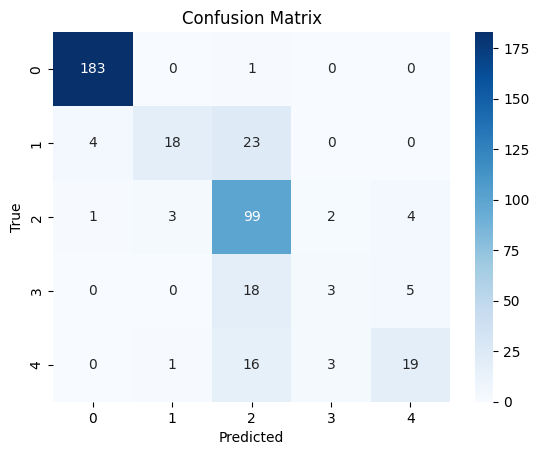

In [ ]:
from sklearn.metrics import confusion_matrix
import seaborn as sns
import matplotlib.pyplot as plt
cm = confusion_matrix(all_labels, all_preds)
sns.heatmap(cm, annot=True, fmt='d', cmap='Blues', xticklabels=test_loader.dataset.classes, yticklabels=test_loader.dataset.classes)
plt.xlabel('Predicted')
plt.ylabel('True')
plt.title('Confusion Matrix')
plt.show()